# Loading GBSG2 to Generate Points for Explained Point
This is for reproduction of SurvNAM. Generated points are needed for each data point, which is called explained point.
We load the GBSG2 dataset as an example to reproduce the work.

## Loading Packages

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# %matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest

## Loading GBSG2

The dataset is loaded as data frame and transformed into numeric values.

In [3]:
# First, we need to load the data and transform it into numeric values.
X, y = load_gbsg2()

grade_str = X.loc[:, "tgrade"].astype(object).values[:, np.newaxis]
grade_num = OrdinalEncoder(categories=[["I", "II", "III"]]).fit_transform(grade_str)

X_no_grade = X.drop("tgrade", axis=1)
Xt = OneHotEncoder().fit_transform(X_no_grade)
Xt.loc[:, "tgrade"] = grade_num

Next, the data is split into 75% for training and 25% for testing, so we can determine how well our model generalizes.

In [4]:
random_state = 20
X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.25, random_state=random_state)

print(X_train.head(3))

      age  estrec  horTh=yes  menostat=Post  pnodes  progrec  tsize  tgrade
292  64.0    71.0        1.0            1.0     1.0    340.0   15.0     1.0
46   65.0     6.0        0.0            1.0     1.0      6.0   20.0     1.0
447  52.0     5.0        0.0            1.0     1.0      8.0   35.0     2.0


| Feature | Description | Type |
| ------- | ----------- | -
| age | age of the patients in years | numeric
| estrec | estrogen receptor | numeric
| horTh | hormonal therapy | binary
| menostat | menopausal status | binary
| pnodes | number of positive nodes | numeric
| progrec | progesterone receptor | numeric
| tsize | tumor size | numeric
| tgrade |tumor grade | categorical

## Training Random Survival Forests
Several split criterion have been proposed in the past, but the most widespread one is based on the
log-rank test, which you probably know from comparing survival curves among two or more groups. Using the training
data, we fit a Random Survival Forest comprising 1000 trees.

In [5]:
rsf = RandomSurvivalForest(n_estimators=1000,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features="sqrt",
                           n_jobs=-1,
                           random_state=random_state)
rsf.fit(X_train, y_train)

# We can check how well the model performs by evaluating it on the test data.
print(rsf.score(X_test, y_test))


0.6759696016771488


## Predicting
For prediction, a sample is dropped down each tree in the forest until it reaches a terminal node. Data
in each terminal is used to non-parametrically estimate the survival and cumulative hazard function using the
Kaplan-Meier and Nelson-Aalen estimator, respectively. In addition, a risk score can be computed that represents
the expected number of events for one particular terminal node. The ensemble prediction is simply the average
across all trees in the forest.

In [6]:
# Let’s first select a couple of patients from the test data according to the number of positive lymph nodes and age.
X_test_sorted = X_test.sort_values(by=["pnodes", "age"])
X_test_sel = pd.concat((X_test_sorted.head(3), X_test_sorted.tail(3)))

# The predicted risk scores indicate that risk for the last three patients is quite a bit higher than that of the
# first three patients.
pd.Series(rsf.predict(X_test_sel))

0     91.477609
1    102.897552
2     75.883786
3    170.502092
4    171.210066
5    148.691835
dtype: float64

We can have a more detailed insight by considering the predicted survival function. It shows that the biggest
difference occurs roughly within the first 750 days.

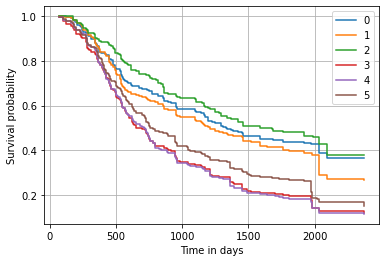

In [7]:
surv = rsf.predict_survival_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.event_times_, s, where="post", label=str(i))

plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)
plt.show()

Alternatively, we can also plot the predicted cumulative hazard function.

      age  estrec  horTh=yes  menostat=Post  pnodes  progrec  tsize  tgrade
119  33.0     0.0        0.0            0.0     1.0     26.0   35.0     2.0
574  34.0    37.0        0.0            0.0     1.0      0.0   40.0     2.0
421  36.0    14.0        0.0            0.0     1.0     76.0   36.0     1.0
24   65.0    64.0        0.0            1.0    26.0      2.0   70.0     2.0
8    80.0    59.0        0.0            1.0    30.0      0.0   39.0     1.0
226  72.0  1091.0        1.0            1.0    36.0      2.0   34.0     2.0


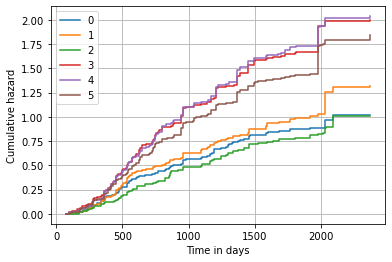

In [13]:
surv = rsf.predict_cumulative_hazard_function(X_test_sel, return_array=True)
print(X_test_sel)

for i, s in enumerate(surv):
    plt.step(rsf.event_times_, s, where="post", label=str(i))

plt.ylabel("Cumulative hazard")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)
plt.show()

## Generate Points for Explained Point
First, we can calculate the largest distance among all points in the dataset.

In [9]:
from sklearn.preprocessing import MinMaxScaler

# create a scaler object
scaler = MinMaxScaler()
# fit and transform the data
X_train_norm = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
print(X_train_norm.head(5))

# print(X_train_norm.shape[0]) number of samples
d_max = 0
for i in range(X_train_norm.shape[0]):
    for j in range(i):
        d_ij = sum((X_train_norm.iloc[i] - X_train_norm.iloc[0])**2)**0.5
        d_max = d_ij if (d_ij >= d_max) else d_max

print(d_max)

        age    estrec  horTh=yes  menostat=Post  pnodes   progrec     tsize  \
0  0.728814  0.066981        1.0            1.0    0.00  0.142857  0.102564   
1  0.745763  0.005660        0.0            1.0    0.00  0.002521  0.145299   
2  0.525424  0.004717        0.0            1.0    0.00  0.003361  0.273504   
3  0.661017  0.007547        1.0            1.0    0.12  0.005882  0.102564   
4  0.593220  0.021698        0.0            1.0    0.00  0.011765  0.162393   

   tgrade  
0     0.5  
1     0.5  
2     1.0  
3     0.0  
4     0.5  
1.7182713691836073


Only numerical feature are considered for the local explanation, including `age`, `estrec`, `pnodes`,
`progrec`, and `tsize`. For the local explanation, the perturbation technique is used. In accordance with the
technique, *N* nearest points are generated in a local area around the explained example.
These points are normally distributed with the center at point x and the standard deviation which is equal to
10% of the largest distance between points of the corresponding studied dataset.

Then we can calculate the largest distances between points for those features used for generating points by
following normal distribution.

In [10]:
d_max_age, d_max_estrec, d_max_pnodes, d_max_progrec, d_max_tsize = 0, 0, 0, 0, 0

for i in range(X_train.shape[0]):
    for j in range(i):
        d_ij_age = abs(X_train.iloc[i].age - X_train.iloc[0].age)
        d_max_age = d_ij_age if (d_ij_age >= d_max_age) else d_max_age

        d_ij_estrec = abs(X_train.iloc[i].estrec - X_train.iloc[0].estrec)
        d_max_estrec = d_ij_estrec if (d_ij_estrec >= d_max_estrec) else d_max_estrec

        d_ij_pnodes = abs(X_train.iloc[i].pnodes - X_train.iloc[0].pnodes)
        d_max_pnodes = d_ij_age if (d_ij_pnodes >= d_max_pnodes) else d_max_pnodes

        d_ij_progrec = abs(X_train.iloc[i].progrec - X_train.iloc[0].progrec)
        d_max_progrec = d_ij_progrec if (d_ij_progrec >= d_max_progrec) else d_max_progrec

        d_ij_tsize = abs(X_train.iloc[i].tsize - X_train.iloc[0].tsize)
        d_max_tsize = d_ij_tsize if (d_ij_tsize >= d_max_tsize) else d_max_tsize

print(d_max_age, d_max_estrec, d_max_pnodes, d_max_progrec, d_max_tsize)

43.0 989.0 19.0 2040.0 105.0


In [16]:
def generate_normal(mean, std, N=100):
    s = np.random.normal(mean, std, N)
    return s

x0 = X_train.iloc[0]
gen_age = generate_normal(x0.age, d_max_age * 0.1)
gen_estrec = generate_normal(x0.estrec, d_max_estrec * 0.1)
gen_pnodes = generate_normal(x0.pnodes, d_max_pnodes * 0.1)
gen_progrec = generate_normal(x0.progrec, d_max_progrec * 0.1)
gen_tsize = generate_normal(x0.tsize, d_max_tsize * 0.1)

df_input = pd.concat([pd.DataFrame(gen_age),
                      pd.DataFrame(gen_estrec)], axis=1)

df_input['horTh=yes'] = x0['horTh=yes']
df_input['menostat=Post'] = x0['menostat=Post']

df_input = pd.concat([df_input,
                      pd.DataFrame(gen_pnodes),
                      pd.DataFrame(gen_progrec),
                      pd.DataFrame(gen_tsize)], axis=1)

df_input['tgrade'] = x0['tgrade']

df_input.columns = ['age', 'estrec', 'horTh=yes', 'menostat=Post', 'pnodes', 'progrec', 'tsize', 'tgrade']
print(df_input)

          age      estrec  horTh=yes  menostat=Post    pnodes     progrec  \
0   63.601928    4.584124        1.0            1.0 -0.103324  117.728936   
1   62.960029  276.363403        1.0            1.0  2.545640  229.492426   
2   63.681699 -113.554604        1.0            1.0  2.894593  196.158686   
3   70.187254  215.312331        1.0            1.0  0.086488  392.370468   
4   66.841078  -20.900151        1.0            1.0  2.720229  495.943519   
..        ...         ...        ...            ...       ...         ...   
95  64.005113   45.076218        1.0            1.0 -1.153318   57.446540   
96  62.254317   99.846982        1.0            1.0  2.173548  391.510779   
97  61.895830  -32.655566        1.0            1.0  1.807776  339.233125   
98  72.406670   52.003095        1.0            1.0  0.753991  180.868527   
99  68.803363   98.166758        1.0            1.0  3.080896  284.602725   

        tsize  tgrade  
0    9.543154     1.0  
1   25.679198     1.0  
2  

### Cumulative Hazard Function by Random Survival Forests

[[1.78902709e-03 1.78902709e-03 1.91715725e-03 ... 4.43018259e-01
  4.43018259e-01 4.52634926e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 5.79522958e-01
  5.92432482e-01 6.27332482e-01]
 [0.00000000e+00 1.70454545e-04 5.94645931e-04 ... 7.82806471e-01
  7.87139804e-01 7.93173138e-01]
 ...
 [2.85714286e-05 7.40259740e-05 4.98217360e-04 ... 7.02409824e-01
  7.09193157e-01 7.29726490e-01]
 [2.03650064e-03 2.06281643e-03 2.06281643e-03 ... 3.57872210e-01
  3.59498400e-01 3.76731734e-01]
 [0.00000000e+00 2.63157895e-05 2.63157895e-05 ... 6.04338303e-01
  6.32190684e-01 6.61174017e-01]]


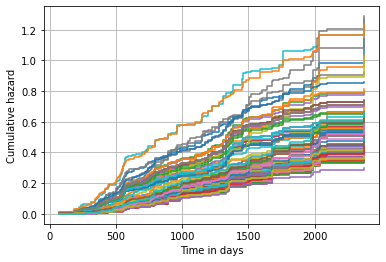

In [49]:
chf_rsf = rsf.predict_cumulative_hazard_function(df_input, return_array=True)

for i, s in enumerate(chf_rsf):
    plt.step(rsf.event_times_, s, where="post", label=str(i))

plt.ylabel("Cumulative hazard")
plt.xlabel("Time in days")
# plt.legend()
plt.grid(True)
plt.show()

### Cumulative Hazard Function by Nelson-Aalen Estimator
The approximating Cox model has the baseline CHF H_0(t) constructed on training data using the Nelson-Aalen estimator.

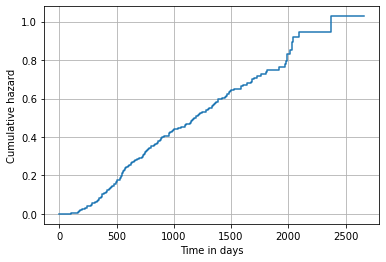

In [56]:
from lifelines.fitters.nelson_aalen_fitter import NelsonAalenFitter

nelson = NelsonAalenFitter()
nelson.fit(durations=pd.DataFrame(y_train).time, event_observed=pd.DataFrame(y_train).cens)

plt.step(nelson.cumulative_hazard_.index, nelson.cumulative_hazard_.NA_estimate, where="post", label=str(i))

plt.ylabel("Cumulative hazard")
plt.xlabel("Time in days")
# plt.legend()
plt.grid(True)
plt.show()